### Описание проекта  
Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.
Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

### 1. Загрузка данных

In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [244]:
try:
    df = pd.read_csv('./datasets/insurance.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/insurance.csv')

df.head()


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


* Пропусков нет
* Тип данных корректный

In [246]:
df[df.duplicated()==True].sort_values('Возраст').head(10)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
2429,1,18.0,39800.0,2,0
2512,1,19.0,43200.0,1,0
2269,1,19.0,43200.0,1,0
4129,1,19.0,35600.0,2,0
2853,0,19.0,51700.0,0,0
2694,1,19.0,52600.0,0,0
4935,1,19.0,32700.0,0,0
4726,1,19.0,31700.0,1,0
887,1,19.0,35500.0,0,0
3419,1,19.0,41600.0,1,0


* Есть дубликаты, и смущает, что зарплата сходится рубль в рубль. Пока оставлю, допуская вероятность того, что в кредитном брокере сотрудник выбирает уровень дохода из списка или брокер округляет указанную сумму.

In [247]:
df['Зарплата'].value_counts().sort_values(ascending=False)

45800.0    29
37100.0    28
41500.0    27
43200.0    27
46800.0    26
           ..
63500.0     1
62600.0     1
15200.0     1
65900.0     1
56800.0     1
Name: Зарплата, Length: 524, dtype: int64

Да, похоже на то. Довольно много повторяющихся значений, шаг зарплаты - 100

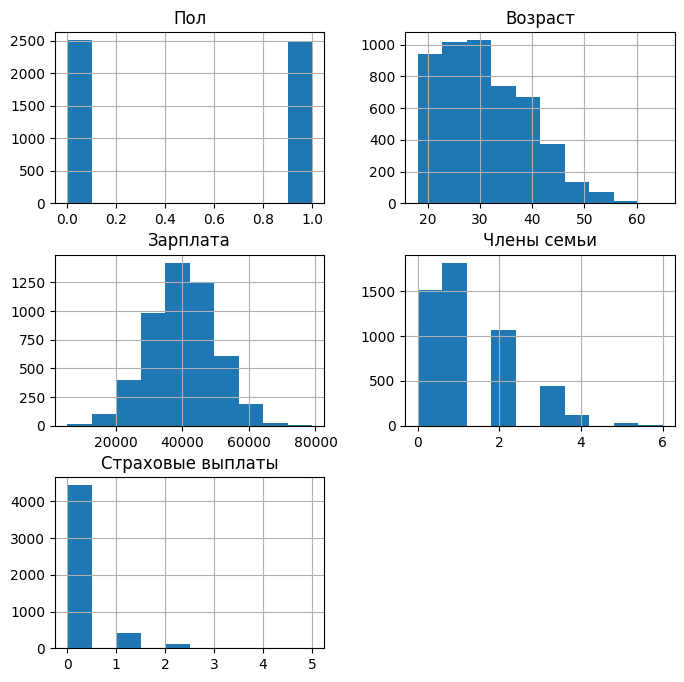

In [248]:
df.hist(figsize=(8,8))
plt.show()

In [249]:
df.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Сильных выпадов я не вижу. Возраст от 18 до 65 скорее всего ограничен програмно. Смущает 5 в страховых выплатах. Также стоит посмотреть на значения.

In [250]:
df['Страховые выплаты'].value_counts()

0    4436
1     423
2     115
3      18
4       7
5       1
Name: Страховые выплаты, dtype: int64

В целом я допускаю, что одному и тому же человека могли сделать несколько выплат, хотя можно заменить все, что больше 1 на 1.

In [251]:
fig = px.imshow(df.corr().round(2),text_auto=True,width=600)
fig.show()

* Мы видим, что между собой признаки не коррелируют.
* Есть корреляция Целевого столбца и возраста 0.65, но для нас это не критично, нам важно, чтобы признаки не коррелировали между собой.

### 2. Умножение матриц  
Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Для начала проверим гипотезу о том, что умножение на обратимую матрицу не искажает предсказания:
1. Обучим модель.
2. Посчитаем основные метрики на изначальной матрице и умноженной. Сравним их.
3. Посмотрим как коррелируют между собой новые метрики.

In [252]:
model = LinearRegression()
X = df.drop('Страховые выплаты', axis=1)
y = df['Страховые выплаты']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=12345)

for i in [X_train, X_test, y_train, y_test]:
    display(i.shape)


(3750, 4)

(1250, 4)

(3750,)

(1250,)

In [253]:
model.fit(X_train ,y_train)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print ("MSE:",mse)
print ("R2:",r2)

MSE: 0.11660517472525776
R2: 0.43522757127025646


Теперь посмотрим как модель сработает на измененных данных:

In [260]:
matrix = np.random.normal(0, 1, (4, 4))
inv_matrix = np.linalg.inv(matrix)
inv_matrix

array([[-2.32480669,  2.88502636,  3.89875566,  0.21806199],
       [-0.97915466,  0.08966567,  0.15368311, -0.33850166],
       [-3.13295839,  3.2941044 ,  4.91773701, -1.10446883],
       [-0.47613093,  0.68379326,  2.19597433,  1.12651137]])

Мы сразу проверили матрицу на обратимость, все в порядке.

Теперь рассчитаем новые веса для обычной матрицы:

In [262]:
X_train_new = X_train @ inv_matrix
X_test_new = X_test @ inv_matrix
model_new = LinearRegression()
model_new.fit(X_train_new,y_train)
predictions_new = model_new.predict(X_test_new)
mse_new = mean_squared_error(y_test, predictions_new)
r2_new = r2_score(y_test, predictions_new)
print ("MSE_new:",mse_new)
print ("R2_new:",r2_new)
print ("MSE_diff", mse-mse_new)
print ("R2_diff", r2-r2_new)

MSE_new: 0.11660517472572146
R2_new: 0.4352275712680106
MSE_diff -4.636985240225044e-13
R2_diff 2.245870156514229e-12


Отлично, качество модели не изменилось.

In [256]:
#Вес изначальной матрицы
w = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
#Вектор предсказаний
a = X_train @ w
#Вес измененной матрицы
w1 = np.linalg.inv(X_train_new.T.dot(X_train_new)).dot(X_train_new.T).dot(y_train)
#Вектор предсказаний для измененной матрицы
a1 = X_train_new @ w1
#Суммарные отличия разниц 2 векторов
print (sum(a1-a))



0.001088073688613106


#### Выводы из 2 части:
1. Мы обосновали, что умножение данных на обратимую матрицу не меняет качество модели.
2. Мы проверили веса и вектора предсказаний с различными параметрами и получили практически одинаковые цифры.

### 3. Алгоритм преобразования


Разработаем универсальную функцию кодирования, которая на вход будет принимать датафрейм с презнаками, а на выходе выдавать преобразованный датафрейм и ключ в виде обратимой матрицы.

In [257]:
def coding(X_for_code):
    matrix = np.random.randint(100,size = (4, 4))
    encoded_features = X_for_code.dot(matrix)
    return encoded_features,matrix

X_coded = coding(X)
X_coded[0].head(5)

,0,1,2,3
0,2729386.0,696029.0,4912840.0,596170.0
1,2091508.0,533723.0,3764720.0,457022.0
2,1155928.0,295044.0,2080682.0,252638.0
3,2294244.0,584690.0,4129622.0,500882.0
4,1436434.0,366494.0,2585534.0,313874.0


Ранее мы доказали, что даже при видоизменении данных, можно будет обучить модель и получить такое же качество. Теперь нам нужно написать функцию, которая позволит вернуться к изначальным данным, т.к. произвести дешифровку. На вход она будет принимать измененную матрицу, а на выходе должна дать изначальную.

In [258]:
def decoding(coded,matrix):
    decoded_features = abs(round(coded @ np.linalg.inv(matrix)))
    decoded_features.columns = X.columns
    return decoded_features

display(decoding(X_coded[0],X_coded[1]).head(5))
display(X.head(5))

,Пол,Возраст,Зарплата,Члены семьи
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0


,Пол,Возраст,Зарплата,Члены семьи
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0


### 4. Проверка алгоритма
Отлично, благодаря 2 функциям мы разработали алгоритм, который при кодировании преобразует данные и выдает ключ, с помощью которого данные можно будет привести к изначальному виду. 

### Итоговые выводы

1. В этом проекте мы убедились в том, что шифровка данных путем умножения на обратимую матрицу не приводит к ухудшению качества данных.
2. Разработали метод шифровки, который генерирует ключ в виде матрицы и позволяет хранить данные в зашифрованном виде.
3. Проверили алгоритм на практике и убедились в высокой точности данного метода.
4. Также в ходе работы была обучена модель, которая предсказывает целевой признак со следующими характеристиками: